# New Generators

In [1]:
import torch
import numpy as np
from torch import nn

class SinSweepMultiToneGen(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self):
        fs = np.random.uniform(100, 10000)
        duration = np.random.uniform(0.1, 10)
        bw = np.random.uniform(100, 200)
        pri = np.random.uniform(0.01, 5)
        fc = np.random.uniform(100, 8000)
        multitone_bw = np.random.uniform(500, 8000)
        num_multitones = np.random.randint(2, 10)
        
        return self.sin_sweep(
            fs=fs,
            duration=duration,
            bw=bw,
            pri=pri,
            fc=fc,
            multitone_bw=multitone_bw,
            num_multitones=num_multitones,
        )
    
    @staticmethod   
    def sin_sweep(
        fs,
        duration,
        bw,
        pri,
        fc,
        multitone_bw,
        num_multitones
    ):
        N = int(fs*duration)
        if N == 0:
            print(fs, duration)
            raise
        t = np.linspace(0, duration, N)
        freq_shifts = np.linspace(-multitone_bw/2, multitone_bw/2 ,num_multitones)
        changing_f = fc + bw*np.sin(2*np.pi*pri*t)
        x_complex = np.array(
            [np.exp(1j*2*np.pi*changing_f) * np.exp(1j*2*np.pi*freq_shift) 
             for freq_shift in freq_shifts]).sum(axis=0)
        x_complex = torch.tensor(x_complex)
        return x_complex

# Dataset

In [2]:
from modules.dataset import SignalDataset
from modules.preprocess import AutoCorrPeak
from modules.augmentation import AWGN
from modules.generators import SinSweepGen,LFMSweepGen, BPSKGen

### Transform

In [3]:
from torch import nn
class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.awgn = AWGN()
        self.autocorr_peak_extractor = AutoCorrPeak(peak_width_factor=200)
        
    def forward(self, x):
        x = self.awgn(x)
        x = self.autocorr_peak_extractor(x)
        return x
    
gen_objs = [SinSweepMultiToneGen()]

In [4]:
ds = SignalDataset(gen_objs, transform=Transform())

In [5]:
# %%timeit
# (peak1abs, _), (peak2abs, _) = next(ds)

### demonstrate data

Text(0.5, 1.0, 'torch.Size([236])')

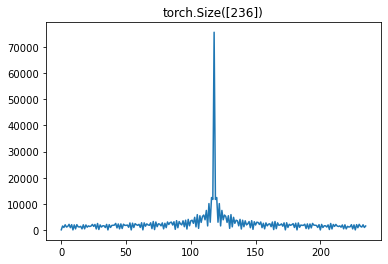

In [6]:
import matplotlib.pyplot as plt
plt.figure()

(peak1abs, _), (peak2abs, _), _ = next(ds)
plt.plot(peak1abs)
plt.title(peak1abs.shape)

Text(0.5, 1.0, '[3.0, 0.6914381173509973]')

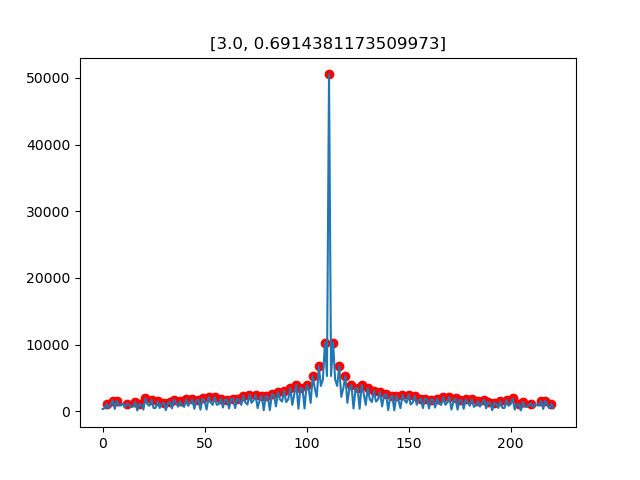

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

%matplotlib widget

(peak1abs, _), (peak2abs, _), _ = next(ds)

prominence = 0.008
height = 0.01

peaks_loc, props = signal.find_peaks(peak1abs/peak1abs.max(), height=height, prominence=prominence)

sorted_peaks_height = sorted(props['peak_heights'], reverse=True)
if len(peaks_loc) > 1:
    peaks_diff = np.diff(peaks_loc)
    sll = np.log10(sorted_peaks_height[0] / sorted_peaks_height[1])  # side lobe level
    features = [np.median(peaks_diff), sll]
else:
    features = []


plt.figure()
plt.plot(peak1abs)
plt.scatter(np.arange(len(peak1abs))[peaks_loc], peak1abs[peaks_loc], c='r')
plt.title(features)

In [97]:
sorted_peaks_height[0] / sorted_peaks_height[1]

8.624201314383047